# Import Libraries and load data

In [1]:
import os
import numpy as np
import pandas as pd

import cv2

import tensorflow as tf
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.optimizers as O
import tensorflow.keras.metrics as ME
import tensorflow.keras.losses as LO

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

In [2]:
# Getting image file paths

bed_files = os.listdir('/content/drive/MyDrive/inGiniousAI/Images/bedroom')
liv_files = os.listdir('/content/drive/MyDrive/inGiniousAI/Images/livingroom')
bed_files = [os.path.join('/content/drive/MyDrive/inGiniousAI/Images/bedroom', i) for i in bed_files]
liv_files = [os.path.join('/content/drive/MyDrive/inGiniousAI/Images/livingroom', i) for i in liv_files]

In [3]:
# preparing pandas dataframe of image paths

data = dict()
data['images'] = bed_files + liv_files
data['labels'] = [1]*(len(bed_files)) + [0]*(len(liv_files))
data = pd.DataFrame(data)
data = data.sample(frac=1, random_state=45).reset_index(drop=True)

In [5]:
data

,images,labels
0,/content/drive/MyDrive/inGiniousAI/Images/livi...,0
1,/content/drive/MyDrive/inGiniousAI/Images/livi...,0
2,/content/drive/MyDrive/inGiniousAI/Images/bedr...,1
3,/content/drive/MyDrive/inGiniousAI/Images/livi...,0
4,/content/drive/MyDrive/inGiniousAI/Images/bedr...,1
...,...,...
1362,/content/drive/MyDrive/inGiniousAI/Images/livi...,0
1363,/content/drive/MyDrive/inGiniousAI/Images/bedr...,1
1364,/content/drive/MyDrive/inGiniousAI/Images/bedr...,1
1365,/content/drive/MyDrive/inGiniousAI/Images/livi...,0


# A glance into the data

In [6]:
data.labels.value_counts()

print('Class count: ')

0    705
1    662
Name: labels, dtype: int64

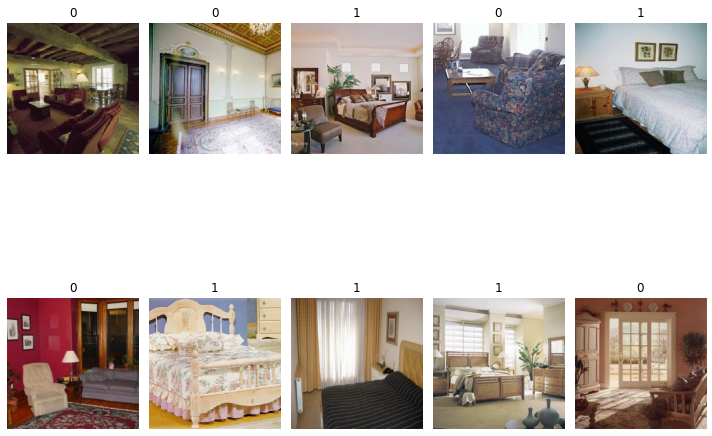

In [7]:
fig, ax = plt.subplots(2,5, figsize=(10,10))

for i in range(10):
    image = cv2.imread(data.images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(256,256), cv2.INTER_NEAREST)
    ax[i//5,i%5].imshow(image)
    ax[i//5,i%5].axis("off")
    ax[i//5,i%5].set_title(data.labels[i])

plt.subplots_adjust(hspace=0)
fig.tight_layout()
plt.show()

# Image preprocessing

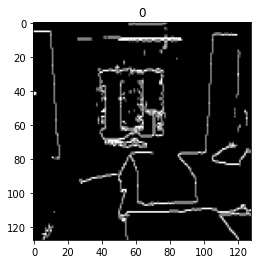

In [8]:
def preprocessor(image: np.ndarray) -> np.ndarray:
    '''
    Image Preprocessor to preprocess the image for training and prediction

    input: np.ndarray
    output: np.ndarray
    '''

    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = cv2.bilateralFilter(image,15, 70, 70)
    # image = cv2.GaussianBlur(image,(3,3),2)
    image = cv2.Canny(image,120,120)
    # ret, image = cv2.threshold(image,150,255,0)
    # image = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, (15,15))
    # contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # image = cv2.drawContours(image, contours, -1, (0,255,0), 3)
    image = cv2.dilate(image, (7,7), 5)
    image = cv2.resize(image, (128,128), cv2.INTER_NEAREST)
    return image

image1 = preprocessor(cv2.imread(data.images[11]))
plt.imshow(image1,cmap='gray')
plt.title(data.labels[1])
plt.show()

In [9]:
!mkdir /content/drive/MyDrive/inGiniousAI/Images/preprocesed
!mkdir /content/drive/MyDrive/inGiniousAI/Images/preprocesed/0
!mkdir /content/drive/MyDrive/inGiniousAI/Images/preprocesed/1

mkdir: cannot create directory ‘/content/drive/MyDrive/inGiniousAI/Images/preprocesed’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/inGiniousAI/Images/preprocesed/0’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/inGiniousAI/Images/preprocesed/1’: File exists


In [10]:
file_path = '/content/drive/MyDrive/inGiniousAI/Images/preprocesed'

In [11]:
preprocessed_data = dict()
image_paths = []
label = []
error_img = []
for i in tqdm(range(len(data))):
    image = cv2.imread(data.images[i])
    if type(image) == type(None):
        error_img.append(data.images[i])
        continue
    image = preprocessor(image)
    cv2.imwrite(os.path.join(file_path,str(data.labels[i])+'/'+str(i)+'.jpeg'),image)
    image_paths.append(os.path.join(file_path,str(data.labels[i])+'/'+str(i)+'.jpeg'))
    label.append(data.labels[i])

preprocessed_data['images'] = image_paths
preprocessed_data['labels'] = label
preprocessed_data = pd.DataFrame(preprocessed_data)

  0%|          | 0/1367 [00:00<?, ?it/s]

In [12]:
preprocessed_data

,images,labels
0,/content/drive/MyDrive/inGiniousAI/Images/prep...,0
1,/content/drive/MyDrive/inGiniousAI/Images/prep...,0
2,/content/drive/MyDrive/inGiniousAI/Images/prep...,1
3,/content/drive/MyDrive/inGiniousAI/Images/prep...,0
4,/content/drive/MyDrive/inGiniousAI/Images/prep...,1
...,...,...
1362,/content/drive/MyDrive/inGiniousAI/Images/prep...,0
1363,/content/drive/MyDrive/inGiniousAI/Images/prep...,1
1364,/content/drive/MyDrive/inGiniousAI/Images/prep...,1
1365,/content/drive/MyDrive/inGiniousAI/Images/prep...,0


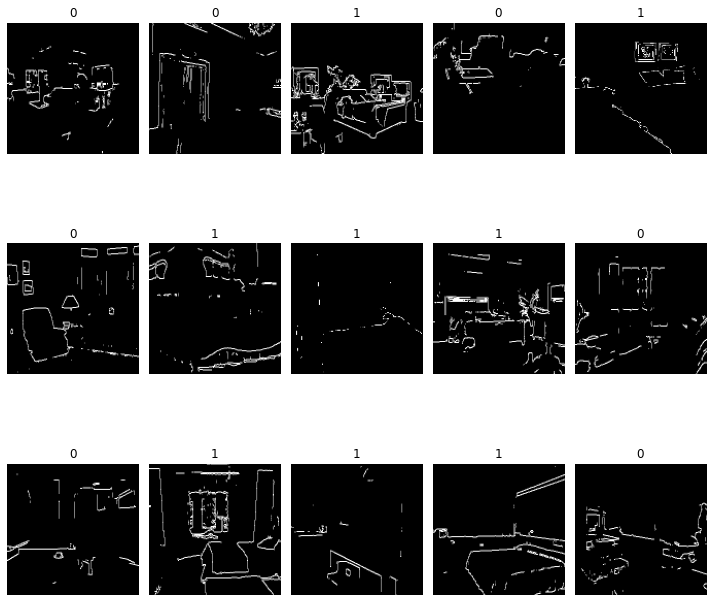

In [13]:
fig, ax = plt.subplots(3,5, figsize=(10,10))

for i in range(15):
    image = preprocessor(cv2.imread(data.images[i]))
    ax[i//5,i%5].imshow(image,cmap='gray')
    ax[i//5,i%5].axis("off")
    ax[i//5,i%5].set_title(data.labels[i])

fig.tight_layout()
plt.show()

# Training

## Global variables

In [14]:
BATCH_SIZE = 16
EPOCHS = 15

## Model Architecture

In [15]:
def build_model():
    '''
    Model architecure for the classification task

    input:  None
    output: tf.Keras.Model
    '''

    inp = L.Input(shape=(128,128,1,))
    x = L.Conv2D(16,(15,15),padding='same',activation='relu')(inp)
    x = L.MaxPooling2D()(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(32,(13,13),padding='same',activation='relu')(x)
    x = L.MaxPooling2D()(x)
    x = L.Dropout(0.3)(x)
    x = L.Add()([x, tf.image.resize(inp, (32,32))])
    x = L.Conv2D(64,(7,7),padding='same',activation='relu')(x)
    x = L.MaxPooling2D()(x)
    x = L.Dropout(0.3)(x)
    x = L.Add()([x, tf.image.resize(inp, (16,16))])
    x = L.Conv2D(128,(5,5),padding='same',activation='relu')(x)
    x = L.MaxPooling2D()(x)
    x = L.Dropout(0.5)(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(256,(3,3),padding='same',activation='relu')(x)
    x = L.MaxPooling2D()(x)
    x = L.Dropout(0.5)(x)
    x = L.BatchNormalization()(x)
    x = L.Flatten()(x)
    x = L.Dense(64,activation='relu')(x)
    x = L.Dense(32,activation='relu')(x)
    x = L.Dense(16,activation='relu')(x)
    out = L.Dense(1,activation='sigmoid',kernel_initializer='glorot_uniform')(x)

    model = M.Model(inputs=inp, outputs=out)
    adam = O.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[ME.AUC()])
    return model

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  3616        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 16)   0           ['conv2d[0][0]']                 
                                                                                              

## Training with cross validation

In [ ]:
def load_data(path, labels=None):
    '''
    Function to load data into the system. it is used for dynamic loading of the data incase the data size is more than the available memory

    input: path string, class label
    output: image tensor, class label
    '''

    image = tf.io.decode_jpeg(tf.io.read_file(path), channels=1)
    if labels == None:
        return image
    return image, labels

In [16]:
# KFold cross validation

kf = KFold(n_splits=5)

for ix, (tr_ix,val_ix) in enumerate(kf.split(preprocessed_data.values)):
    print(f"################### FOLD {ix+1} ###################")

    model = build_model()

    tr_dataset = tf.data.Dataset.from_tensor_slices((preprocessed_data.iloc[tr_ix].images.values, preprocessed_data.iloc[tr_ix].labels.values)).map(load_data, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(BATCH_SIZE,drop_remainder=True).repeat().prefetch(tf.data.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((preprocessed_data.iloc[val_ix].images.values, preprocessed_data.iloc[val_ix].labels.values)).map(load_data, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(BATCH_SIZE,drop_remainder=True).repeat().prefetch(tf.data.AUTOTUNE)

    history = model.fit(tr_dataset,
                        steps_per_epoch=len(tr_ix)//BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=val_dataset,
                        validation_batch_size=BATCH_SIZE,
                        validation_steps=len(val_ix)//BATCH_SIZE)
    
    print('Validation data AUC score:', model.evaluate(val_dataset,verbose=0,steps=len(val_ix)//BATCH_SIZE)[1])

################### FOLD 1 ###################
Epoch 1/15
68/68 [==============================] - 8s 60ms/step - loss: 0.6673 - auc_1: 0.6650 - val_loss: 0.9008 - val_auc_1: 0.7241
Epoch 2/15
68/68 [==============================] - 3s 50ms/step - loss: 0.6457 - auc_1: 0.6752 - val_loss: 0.6089 - val_auc_1: 0.7451
Epoch 3/15
68/68 [==============================] - 3s 50ms/step - loss: 0.6283 - auc_1: 0.6964 - val_loss: 0.5782 - val_auc_1: 0.7507
Epoch 4/15
68/68 [==============================] - 3s 50ms/step - loss: 0.6215 - auc_1: 0.7020 - val_loss: 0.5667 - val_auc_1: 0.7609
Epoch 5/15
68/68 [==============================] - 3s 50ms/step - loss: 0.6127 - auc_1: 0.7194 - val_loss: 0.5957 - val_auc_1: 0.7487
Epoch 6/15
68/68 [==============================] - 3s 50ms/step - loss: 0.5918 - auc_1: 0.7359 - val_loss: 0.5569 - val_auc_1: 0.7759
Epoch 7/15
68/68 [==============================] - 3s 49ms/step - loss: 0.5795 - auc_1: 0.7496 - val_loss: 0.5972 - val_auc_1: 0.7610
Epoch 8/

## Save model

In [24]:
model.save('/content/drive/MyDrive/inGiniousAI/model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Inference

## Load Test Data

The images used for testing are images from captured from my own phone

In [17]:
test_files = os.listdir('/content/drive/MyDrive/inGiniousAI/Images/Test/')

In [18]:
test_files = [os.path.join('/content/drive/MyDrive/inGiniousAI/Images/Test', i) for i in test_files]

## Preprocess data

In [19]:
test_images = np.zeros((len(test_files),128,128,1))

for i in range(len(test_files)):
    image = cv2.imread(test_files[i])
    image = cv2.resize(image, (256,256))
    test_images[i] = np.expand_dims(preprocessor(image),axis=-1)

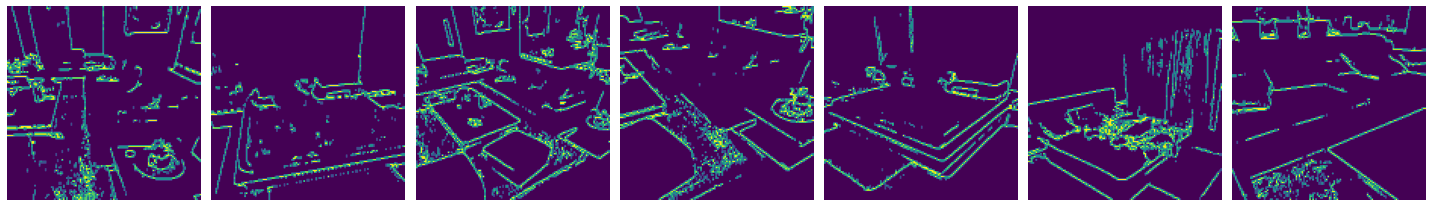

In [20]:
fig, ax = plt.subplots(1,len(test_files), figsize=(20,5))

for i in range(len(test_files)):
    ax[i].imshow(np.squeeze(test_images[i],axis=-1))
    ax[i].axis('off')

fig.tight_layout()
plt.show()

## Prediction

In [21]:
pred = model.predict(test_images)

In [26]:
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0

## Result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  """


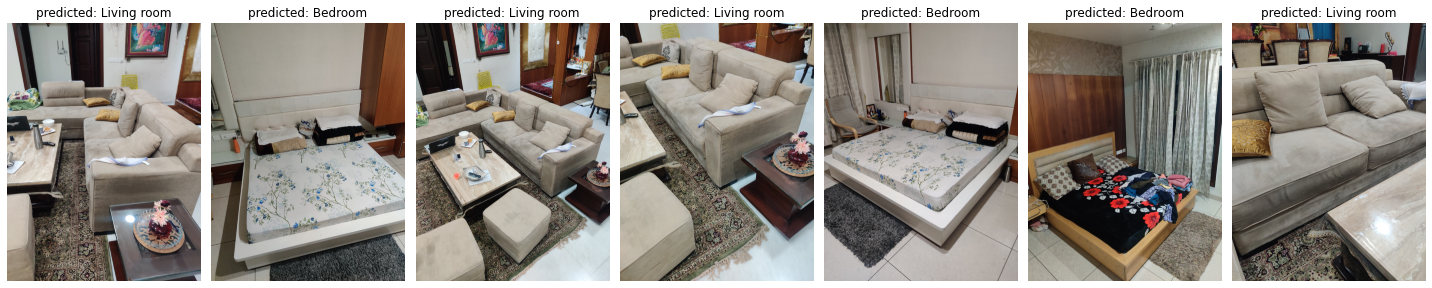

In [31]:
fig, ax = plt.subplots(1,len(test_files), figsize=(20,5))

for i in range(len(test_files)):
    ax[i].imshow(cv2.cvtColor(cv2.imread(test_files[i]), cv2.COLOR_BGR2RGB))
    ax[i].set_title(f"Predicted: {'Bedroom'*(pred[i][0] == 1) + 'Living room'*(pred[i][0] == 0)}")
    ax[i].axis('off')

fig.tight_layout()
plt.show()